## Problem Statement:
### Predict whether it will rain today or not based on weather measurements.

## Coding:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from timeit import default_timer
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

from xgboost import XGBClassifier
from embedding_encoder import EmbeddingEncoder
from embedding_encoder.utils.compose import ColumnTransformerWithNames

In [3]:
#data source: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

In [4]:
rain = pd.read_csv("data/weatherAUS.csv")

In [5]:
rain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### Drop features

In [6]:
cols_to_drop = ["Date", "Location", "RainTomorrow", "Rainfall"]

In [7]:
rain.drop(cols_to_drop, axis=1, inplace=True)

In [8]:
missing_props = rain.isna().mean(axis=0)

In [9]:
over_threshold = missing_props[missing_props >= 0.4]

In [10]:
rain.drop(over_threshold.index, 
          axis=1, 
          inplace=True)

In [11]:
X = rain.drop("RainToday", axis=1)

In [12]:
y = rain['RainToday']

In [13]:
X.info()  #12 numerical and 3 categorical features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   MinTemp        143975 non-null  float64
 1   MaxTemp        144199 non-null  float64
 2   WindGustDir    135134 non-null  object 
 3   WindGustSpeed  135197 non-null  float64
 4   WindDir9am     134894 non-null  object 
 5   WindDir3pm     141232 non-null  object 
 6   WindSpeed9am   143693 non-null  float64
 7   WindSpeed3pm   142398 non-null  float64
 8   Humidity9am    142806 non-null  float64
 9   Humidity3pm    140953 non-null  float64
 10  Pressure9am    130395 non-null  float64
 11  Pressure3pm    130432 non-null  float64
 12  Cloud9am       89572 non-null   float64
 13  Temp9am        143693 non-null  float64
 14  Temp3pm        141851 non-null  float64
dtypes: float64(12), object(3)
memory usage: 16.6+ MB


In [14]:
X['WindDir9am'].unique()  #categorical variable: categorical values (fixed number of possible values (categories; levels))

array(['W', 'NNW', 'SE', 'ENE', 'SW', 'SSE', 'S', 'NE', nan, 'SSW', 'N',
       'WSW', 'ESE', 'E', 'NW', 'WNW', 'NNE'], dtype=object)

In [15]:
y.shape[0]

145460

In [16]:
y.notna().sum()  #non-null values count

142199

In [17]:
y.isna().sum()  #null values count

3261

In [18]:
y.value_counts()  #target distribution of labels

No     110319
Yes     31880
Name: RainToday, dtype: int64

### Preprocessing

In [19]:
categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ordinal", OrdinalEncoder()),
    ]
)

In [20]:
from sklearn.preprocessing import StandardScaler

numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), 
           ("scale", StandardScaler())]
)

In [21]:
cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

In [22]:
full_processor = ColumnTransformerWithNames(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),  #pattern: (name, transformer, coulmns)
    ]
)

In [23]:
#target values transformed
y = SimpleImputer(strategy="most_frequent").fit_transform(y.values.reshape(-1, 1))  #fill missing values
y_processed = LabelEncoder().fit_transform(y.ravel())  #encode labels as integers

In [24]:
start = default_timer()
X_processed = full_processor.fit_transform(X)
end = default_timer()
print(f'Time elapsed (hh:mm:ss.ms) {timedelta(seconds=end-start)}')

Time elapsed (hh:mm:ss.ms) 0:00:00.759034


### Analyze preprocessed data

In [25]:
list(cat_cols)

['WindGustDir', 'WindDir9am', 'WindDir3pm']

In [26]:
full_processor.transformers_[1][1]['ordinal'].n_features_in_

3

In [27]:
full_processor.transformers_[1][1]['ordinal'].categories_

[array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW'], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW'], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW'], dtype=object)]

In [28]:
full_processor.transformers_[1][1]['ordinal'].categories_[0].shape

(16,)

In [29]:
len(num_cols)

12

In [30]:
X_processed.shape

(145460, 15)

In [31]:
X_processed.columns

Index(['MinTemp', 'MaxTemp', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Temp9am', 'Temp3pm', 'WindGustDir', 'WindDir9am', 'WindDir3pm'],
      dtype='object')

In [32]:
X_processed['WindDir9am'].value_counts().index.sort_values(ascending=True) 

Float64Index([ 0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0,
              11.0, 12.0, 13.0, 14.0, 15.0],
             dtype='float64')

### Split data into training, evaluation and test dataset

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, stratify=y_processed, random_state=42)  #total=100%; train=75%; test=25%
X_train_short, X_val, y_train_short, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=42)    #train_short=56% total; val=19% total; train_short=3/4*3/4=9/16=0.56; val=3/4*1/4=3/16=0.19

### Tune number of decision trees

In [34]:
best_params = {
    'gamma': 0.25,
    'learning_rate': 0.1,
    'max_depth': 7,
    'reg_lambda': 10,
    'scale_pos_weight': 1,
}

In [35]:
explore_n_estimators = 600

In [36]:
model = XGBClassifier(
    n_estimators=explore_n_estimators,
    **best_params,
    objective="binary:logistic",
    colsample_bytree=0.5,
    subsample=0.8,
    use_label_encoder=False
)

In [37]:
eval_set = [(X_train_short, y_train_short), (X_val, y_val)]  #metric applied on both train and val dataset

In [38]:
start = default_timer()
model.fit(X_train_short, y_train_short, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
end = default_timer()
print(f'Time elapsed (hh:mm:ss.ms) {timedelta(seconds=end-start)}')

Time elapsed (hh:mm:ss.ms) 0:00:45.449819


In [39]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy * 100.0:.2f}')

Accuracy: 84.98


In [40]:
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

In [41]:
logloss_errors = results['validation_1']['logloss']  #log loss on val dataset

In [42]:
min_logloss_errors = np.min(logloss_errors); min_logloss_errors

0.337332

In [43]:
bst_n_estimators = np.argmin(logloss_errors); bst_n_estimators

341

In [44]:
acc_error = results['validation_1']['error']  #accuracy on val dataset

In [45]:
min_acc_error = np.min(acc_error); min_acc_error

0.14842

In [46]:
bst_n_estimators_acc = np.argmin(acc_error); bst_n_estimators_acc

368

In [47]:
len(results['validation_0']['logloss'])

600

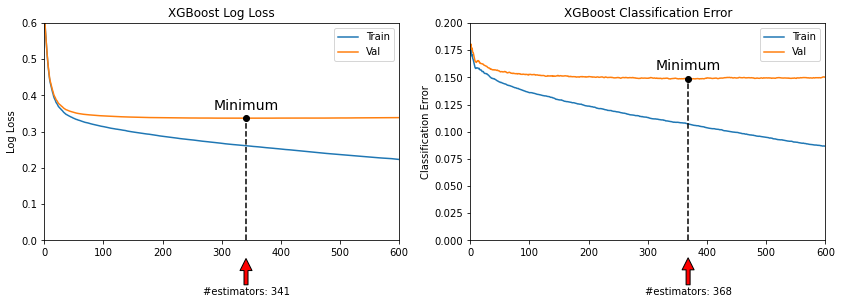

In [48]:
# plot log loss
plt.figure(figsize=(14, 4))
#fig, ax = plt.subplots()
plt.subplot(121)
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Val')
plt.annotate("#estimators: "+str(bst_n_estimators), 
            xy =(bst_n_estimators, -0.05),
            xytext =(bst_n_estimators, -0.15),
            horizontalalignment="center",
            arrowprops=dict(facecolor ='red'),
            annotation_clip=False
           )
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_logloss_errors], "k--")
plt.plot(bst_n_estimators, min_logloss_errors, "ko")
plt.text(bst_n_estimators, min_logloss_errors*1.07, "Minimum", ha="center", fontsize=14)
plt.axis([0, explore_n_estimators, 0, 0.6])
plt.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')

# plot classification error
plt.subplot(122)
plt.plot(x_axis, results['validation_0']['error'], label='Train')
plt.plot(x_axis, results['validation_1']['error'], label='Val')
plt.annotate("#estimators: "+str(bst_n_estimators_acc), 
            xy =(bst_n_estimators_acc, -0.016),
            xytext =(bst_n_estimators_acc, -0.05),
            horizontalalignment="center",
            arrowprops=dict(facecolor ='red'),
            annotation_clip=False
           )
plt.plot([bst_n_estimators_acc, bst_n_estimators_acc], [0, min_acc_error], "k--")
plt.plot(bst_n_estimators_acc, min_acc_error, "ko")
plt.text(bst_n_estimators_acc, min_acc_error*1.06, "Minimum", ha="center", fontsize=14)
plt.axis([0, explore_n_estimators, 0, 0.2])
plt.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')

plt.show()

### Train XGBoost classifier with optimal number of decision trees

In [49]:
bst_n_estimators

341

In [50]:
final_cl = XGBClassifier(
    n_estimators=bst_n_estimators,
    **best_params,
    colsample_bytree=0.5,
    subsample=0.8,
    use_label_encoder=False,
    verbosity = 0
)

In [51]:
start = default_timer()
final_cl.fit(X_train, y_train, verbose=False)
end = default_timer()
print(f'Time elapsed (hh:mm:ss.ms) {timedelta(seconds=end-start)}')

Time elapsed (hh:mm:ss.ms) 0:00:27.899023


### Performance of XGBoost classifier

In [52]:
final_cl.score(X_test,y_test)

0.8521105458545305

In [53]:
roc_auc_score(y_test, final_cl.predict_proba(X_test)[:,1])

0.88331982299356

In [54]:
print(classification_report(y_test, final_cl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     28395
           1       0.72      0.53      0.61      7970

    accuracy                           0.85     36365
   macro avg       0.80      0.74      0.76     36365
weighted avg       0.84      0.85      0.84     36365



### Determine top-level features

In [55]:
final_cl.feature_importances_.shape

(15,)

In [56]:
list_of_tuples = list(zip(X_train.columns.to_numpy(), final_cl.feature_importances_))

In [57]:
df = pd.DataFrame(list_of_tuples, columns = ['score', 'feature_importances']).sort_values('feature_importances',ascending=False)

In [58]:
df.head()

,score,feature_importances
5,Humidity9am,0.212988
6,Humidity3pm,0.153657
0,MinTemp,0.073973
1,MaxTemp,0.060877
2,WindGustSpeed,0.058171


In [59]:
skew_ness = df['feature_importances'].skew()

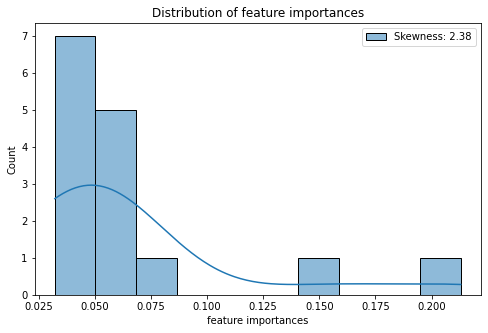

In [60]:
plt.figure(figsize = (8, 5))
ax = sns.histplot(df['feature_importances'], label = f'Skewness: {skew_ness:.2f}', bins=10, kde=True)
ax.set(xlabel='feature importances')
plt.legend(loc = 'best')
plt.title('Distribution of feature importances')
plt.show()

In [61]:
cum_sum_features = pd.DataFrame(np.cumsum(df['feature_importances']))

In [62]:
cum_sum_features.head()

,feature_importances
5,0.212988
6,0.366645
0,0.440618
1,0.501494
2,0.559665


In [63]:
top_features_threshold = 0.8  #threshold for accumulative feature importance

In [64]:
#get features for cumulative feature importance of 80%
num_best_features = cum_sum_features[cum_sum_features['feature_importances']<top_features_threshold].shape[0]
num_best_features

9

In [65]:
list(cat_cols)  #categorical features

['WindGustDir', 'WindDir9am', 'WindDir3pm']

In [66]:
X_train.columns[:num_best_features]  

Index(['MinTemp', 'MaxTemp', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm'],
      dtype='object')